In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from pathlib import Path
import shutil
import pandas as pd  
import richdem as rd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch import FloatTensor
from sklearn.preprocessing import MinMaxScaler
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR, MultiStepLR
from sklearn.metrics import confusion_matrix

In [2]:
dataset_dirs = 'MarsData/DataFrames/three_channel_dataset.csv'

# train_dirs_path = 'MarsData/DataFrames/three_channel_train.csv'
# train_dirs_path = 'MarsData/DataFrames/three_channel_train(NO GAN).csv'
# train_dirs_path = 'MarsData/DataFrames/three_channel_train_only_new_gans.csv'
# train_dirs_path = 'MarsData/DataFrames/three_channel_train_with_gan_new_with_bezier.csv'
# validate_dirs_path = 'MarsData/DataFrames/three_channel_valid.csv'
train_dirs_path = 'MarsData/DataFrames/new_train.csv'
validate_dirs_path = 'MarsData/DataFrames/new_valid.csv'

test_dirs_path = 'MarsData/DataFrames/three_channel_test.csv'

In [3]:
scaler = MinMaxScaler()

In [4]:
class Dataset(BaseDataset):    
    CLASSES = ['non-mound', 'mound']
    
    def __init__(
          self, 
          dirs,
          classes=None,
          augmentation=None):
        self.df = pd.read_csv(dirs)
        self.ids = self.df.index.to_list()

        # convert str names to class values on masks
        self.class_values = CLASSES = [0, 1]


        self.augmentation = augmentation
    
    def __getitem__(self, i):
        # read data
        if self.df.at[i, 'origin'][-3:] == 'tif':
            with rasterio.open(self.df.at[i, 'origin'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','./MarsData')) as dem:
                dem_array = dem.read(1)

            with rasterio.open(self.df.at[i, 'hillshade'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','./MarsData')) as hillshade:
                hillshade_array = hillshade.read(1)

            with rasterio.open(self.df.at[i, 'slope'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','./MarsData')) as slope:
                slope_array = slope.read(1)

            with rasterio.open(self.df.at[i, 'mask'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','./MarsData')) as mask:
                mask_array = mask.read(1)
            mask_array = np.where(mask_array == 0.5, 0, mask_array)
            # apply augmentations
            if self.augmentation:

                sample1 = self.augmentation(image=dem_array)
                dem_array= sample1['image']

                sample2 = self.augmentation(image=slope_array)
                slope_array = sample2['image']           

                sample3 = self.augmentation(image=hillshade_array)
                hillshade_array = sample3['image']

            input_array = [dem_array, slope_array, hillshade_array]
            input_array = np.stack(input_array, axis=0).astype('float')
            input_array = FloatTensor(input_array)
            mask_array = FloatTensor(np.expand_dims(mask_array,axis=(0)))
        
        elif self.df.at[i, 'origin'][-3:] == 'jpg':
            # load the image
            image = Image.open(self.df.at[i, 'origin'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','./MarsData'))
            mask = Image.open(self.df.at[i, 'mask'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','./MarsData')).convert('L')
            # convert image to numpy array
            input_array = np.asarray(image)
            input_array.transpose(2, 0, 1).astype('float32')
            mask_array = np.asarray(mask)
            mask_array = scaler.fit_transform(mask_array)
            mask_array = mask_array[ : ,0]            
            input_array = np.resize(input_array, (3, 224, 192))
            mask_array = np.resize(input_array, (224, 192))
            mask_array [mask_array >= 0.5] = 1 
            mask_array [mask_array < 0.5] = 0
            mask_array = FloatTensor(np.expand_dims(mask_array,axis=(0)))    
            input_array = FloatTensor(input_array)

        return input_array, mask_array
      
    def __len__(self):
        return len(self.ids)

In [5]:
def recall(tp, fn):
    if tp+fn == 0:
        return 'invalid'
    return float(tp)/float(tp+fn)

def precision(tp, fp):
    if tp+fp == 0:
        return 'invalid'
    return float(tp)/float(tp+fp)

def f1_score(tp, fp, fn):
    if tp+fp+fn == 0:
        return 'invalid'
    return float(tp)/(tp + (float(fp + fn)/2))

def for_metric(fn, tn):
    if fn+tn == 0:
        return 'invalid'
    return float(fn)/(fn+tn)

def fdr(fp, tp):
    if fp+tp == 0:
        return 'invalid'
    return float(fp)/(fp+tp)

In [6]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet' 
ACTIVATION = 'sigmoid' 
CLASSES = [1, 0]

model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    in_channels=3,
    activation=ACTIVATION,
)

# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_depth = 5,
#     decoder_channels = (256, 128, 128, 64, 32),
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=1, 
#     in_channels=3,
#     activation=ACTIVATION,
# )

In [7]:
train_dataset = Dataset(train_dirs_path,                        
                        classes=CLASSES)


valid_dataset = Dataset(validate_dirs_path,
                        classes=CLASSES)
# num_workers=2
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [8]:
threshold = 0.5

In [9]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=threshold),
    smp.utils.metrics.IoU(threshold=threshold)
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

optimizer.param_groups[0]['lr']

0.0001

In [10]:
!nvidia-smi

Tue Feb  8 06:29:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:86:00.0 Off |                    0 |
| N/A   73C    P0    97W / 149W |   1113MiB / 11441MiB |     47%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:87:00.0 Off |                    0 |
| N/A   

In [11]:
device = torch.device("cuda:0")

In [12]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model.to(device), 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model.to(device), 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [13]:
# train model for 40 epochs
train_loss=[]
valid_loss=[]
train_fscore=[]
valid_fscore=[]
min_loss = float("inf")
max_score = 0
max__IOU_score = 0
state_not_changed = 0
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
# scheduler = CosineAnnealingLR(optimizer, T_max=len(train_dataset))
for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_loss.append(train_logs['dice_loss'])
    valid_loss.append(valid_logs['dice_loss'])
    train_fscore.append(train_logs['fscore'])
    valid_fscore.append(valid_logs['fscore'])
    state_not_changed+=1
    scheduler1.step()
    scheduler2.step()  

    # do something (save model, change lr, etc.)
    if min_loss > valid_logs['dice_loss']:
        min_loss = valid_logs['dice_loss']
        torch.save(model, './best_loss_model.pth')
        print('best_loss_model saved!')
        state_not_changed = 0
        
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './best_score_model.pth')
        print('best_score_model saved!')
        state_not_changed = 0
    if max__IOU_score < valid_logs['iou_score']:
        max__IOU_score = valid_logs['iou_score']
        torch.save(model, './best_iou_score_model.pth')
        print('best_iou_score_model saved!')
        state_not_changed = 0

    if i % 10 == 0 and i != 0:
        print('Current learning rate = '+str(optimizer.param_groups[0]['lr'])+'!')
#         optimizer.param_groups[0]['lr'] /= 10
#         print('Decrease decoder learning rate to '+str(optimizer.param_groups[0]['lr'])+'!')
#         state_not_changed = 0
        
    if state_not_changed == 25:
        print('The model did not improve during the last 25 epochs')
        torch.save(model, './last_epoch_reached_model.pth')
        print('last_epoch_reached_model saved!')
        break


Epoch: 0
valid: 100%|████████████████████| 24/24 [01:04<00:00,  2.70s/it, dice_loss - 0.2732, fscore - 0.7274, iou_score - 0.572]
best_loss_model saved!
best_score_model saved!
best_iou_score_model saved!

Epoch: 1
valid: 100%|███████████████████| 24/24 [00:58<00:00,  2.45s/it, dice_loss - 0.2669, fscore - 0.7336, iou_score - 0.5796]
best_loss_model saved!
best_score_model saved!
best_iou_score_model saved!

Epoch: 2
valid: 100%|████████████████████| 24/24 [00:57<00:00,  2.41s/it, dice_loss - 0.265, fscore - 0.7358, iou_score - 0.5824]
best_loss_model saved!
best_score_model saved!
best_iou_score_model saved!

Epoch: 3
valid: 100%|███████████████████| 24/24 [00:57<00:00,  2.41s/it, dice_loss - 0.2641, fscore - 0.7363, iou_score - 0.5831]
best_loss_model saved!
best_score_model saved!
best_iou_score_model saved!

Epoch: 4
valid: 100%|███████████████████| 24/24 [00:57<00:00,  2.41s/it, dice_loss - 0.2655, fscore - 0.7351, iou_score - 0.5816]

Epoch: 5
valid: 100%|████████████████████| 2

valid: 100%|████████████████████| 24/24 [00:43<00:00,  1.81s/it, dice_loss - 0.2616, fscore - 0.7387, iou_score - 0.586]

Epoch: 30
valid: 100%|███████████████████| 24/24 [00:57<00:00,  2.41s/it, dice_loss - 0.2585, fscore - 0.7418, iou_score - 0.5901]
Current learning rate = 3.815204244769462e-07!

Epoch: 31
valid: 100%|███████████████████| 24/24 [01:10<00:00,  2.92s/it, dice_loss - 0.2591, fscore - 0.7411, iou_score - 0.5895]

Epoch: 32
valid: 100%|███████████████████| 24/24 [01:05<00:00,  2.71s/it, dice_loss - 0.2613, fscore - 0.7389, iou_score - 0.5862]

Epoch: 33
valid: 100%|███████████████████| 24/24 [01:11<00:00,  2.96s/it, dice_loss - 0.2636, fscore - 0.7367, iou_score - 0.5835]

Epoch: 34
valid: 100%|███████████████████| 24/24 [01:11<00:00,  2.97s/it, dice_loss - 0.2646, fscore - 0.7356, iou_score - 0.5822]

Epoch: 35
valid: 100%|███████████████████| 24/24 [01:10<00:00,  2.96s/it, dice_loss - 0.2629, fscore - 0.7373, iou_score - 0.5842]

Epoch: 36
valid: 100%|█████████████████

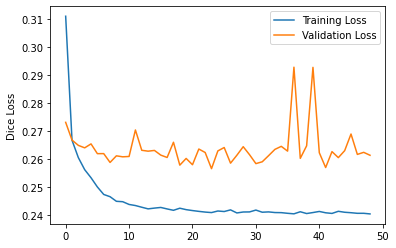

In [14]:
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.ylabel("Dice Loss")
plt.legend()

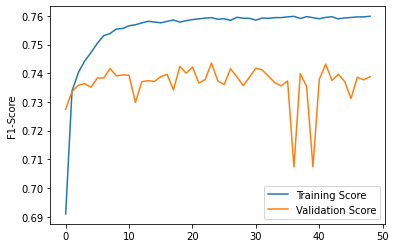

In [15]:
plt.plot(train_fscore, label='Training Score')
plt.plot(valid_fscore, label='Validation Score')
plt.ylabel("F1-Score")
plt.legend()

In [16]:
# load best saved checkpoint
# best_model = torch.load('./FPN_3c_Without.pth') #done
# best_model = torch.load('./FPN_3c_With_GAN.pth')
# best_model = torch.load('./Unet_3c_With_GAN.pth')
# best_model = torch.load('./Unet_3c_Without.pth')
best_model = torch.load('./best_loss_model.pth')
# best_model = torch.load('./best_score_model.pth')
# best_model = torch.load('./last_epoch_reached_model.pth')
# best_model = torch.load('./1.pth')
# best_model = torch.load('./2.pth')

In [17]:
# create test dataset
test_dataset = Dataset(test_dirs_path)

test_dataloader = DataLoader(test_dataset)

In [18]:
# evaluate model on test set
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=threshold)    
    ]
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████████████████████████████| 546/546 [00:40<00:00, 13.53it/s, dice_loss - 0.3104, iou_score - 0.7996]


In [19]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [20]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(test_dirs_path)

In [21]:
# # idx = [25, 30, 36, 38, 42, 53, 54]
# for i in range(len(test_dataset)):
# # for i in idx:
# #     n = np.random.choice(len(test_dataset))
#     n=i
#     image_vis = test_dataset_vis[n][0]
#     image, gt_mask = test_dataset[n]
    
#     x_tensor = image.unsqueeze(0)
#     pr_mask = best_model.predict(x_tensor)
#     pr_mask = (pr_mask.squeeze().cpu().numpy().round())

#     visualize(
#         image=image_vis[2], 
#         ground_truth_mask=gt_mask[0], 
#         predicted_mask=pr_mask
#     )

In [22]:
# threshold=0.35

In [23]:
results = pd.DataFrame(columns=['id', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
# for i, sample in enumerate(test_dataset):
# idx = [75, 256, 269, 321, 406, 415, 504]
for i in range(len(test_dataset)):
    correct = 0
    sample = test_dataset[i]
    im = sample[0].unsqueeze(0).float()#.to(device)
    mask = sample[1].float()#.to(device)
    out = best_model(im).detach()    
    pred = out
    pred[out >= threshold] = 1
    pred[out < threshold] = 0
    correct += (pred == mask).sum().item()
    total = len(mask.view(-1))
    accuracy = float(correct)/total
    # Sklearn doc
    tn, fp, fn, tp = confusion_matrix(mask.view(-1), pred.view(-1), labels=[0., 1.]).ravel()
    
    tmp = pd.DataFrame(columns=['id', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
    tmp['id'] = [i]
    tmp['tp'] = [tp]
    tmp['fp'] = [fp]
    tmp['tn'] = [tn]
    tmp['fn'] = [fn]
    results = results.append(tmp)

In [24]:
ttp = np.sum(results['tp'].values)
tfp = np.sum(results['fp'].values)
ttn = np.sum(results['tn'].values)
tfn = np.sum(results['fn'].values)

In [25]:
print(f'tp = {ttp}, fp = {tfp}, tn={ttn}, fn ={tfn} \n Accuracy = {accuracy}, precision = {precision(tp=ttp, fp=tfp)}, recall = {recall(tp=ttp, fn=tfn)} \n')
print(f'FDR = {fdr(fp=tfp, tp=ttp)}, FOR = {for_metric(fn=tfn, tn=ttn)}\n F-Score = {f1_score(tp= ttp, fp= tfp, fn= tfn)}')

tp = 1508377, fp = 396292, tn=21026712, fn =550987 
 Accuracy = 0.9684244791666666, precision = 0.7919365517053094, recall = 0.7324479790848049 

FDR = 0.20806344829469056, FOR = 0.025535021134551927
 F-Score = 0.7610315050354021
